# Thetis GPS Validation Notebook

In [72]:
# Imports and constants
from ctypes import sizeof
from util import ThetisData
import matplotlib.pyplot as plt
import datetime as dt
from math import pi
import numpy as np
from pyproj import Proj, Transformer
import math

## Read in Thetis Data

In [82]:
i = 0
with open('data/GPS_Test_Indialantic_10Hz.bin', 'rb') as file:
    epoch_data = []
    lat_data = []
    lon_data = []
    fix_data = []

    data = ThetisData()
    while file.readinto(data) == sizeof(data):
        i = i+1
        if (i % 9 != 0): # Only return every [Sample Rate/ GPS Refresh Rate] value
            continue
        timestamp = dt.datetime.utcfromtimestamp(data.epoch) + dt.timedelta(milliseconds=data.mSecond)
        if (data.latitude==0 or data.longitude==0 or not data.GPSFix): # Remove zeros from the signal
            continue
        epoch_data.append(timestamp)
        lat_data.append(data.latitude / 1E6)
        lon_data.append(data.longitude / 1E6)
        fix_data.append(data.GPSFix)

    epoch_data = np.array(epoch_data)
    lat_data = np.array(lat_data)
    lon_data = np.array(lon_data)
    fix_data = np.array(fix_data)

    print("N samples: ", np.size(lat_data))
    print(lat_data)
    print(lon_data)


N samples:  53475
[28.091703 28.091703 28.091703 ... 28.091426 28.091426 28.091426]
[-80.566051 -80.56605  -80.56605  ... -80.566073 -80.566073 -80.566073]


## Calculate Delta X and Delta Y
First, we convert the readings into UTM projection Northings and Eastings in meters, based on NAD 83(2011)

In [86]:
core = (28.091724647222, -80.56607002778)
# xx, yy = Transformer.from_crs("EPSG:4269", "EPSG:4326")
# print(xx, yy)
P = Proj(proj='utm', zone=17, ellps='WGS84', preserve_units=True)
core_xx, core_yy = P(core[1], core[0])
test_xx, test_yy = P(lon_data, lat_data)
print((core_xx, core_yy))
print((test_xx, test_yy))

delta_x = test_xx - core_xx
delta_y = test_yy - core_yy
print(delta_x)
print(delta_y)

# Calculate standard deviation in X
N_x = np.size(test_xx)
mu_x = np.mean(test_xx)
sigma_x = np.std(delta_x)
print("Sigma_x: ", sigma_x)

# Calculate standard deviation in Y
N_y = np.size(test_yy)
mu_y = np.mean(test_yy)
sigma_y = np.std(delta_y)
print("Sigma_y: ", sigma_y)

# Calculate Circle of Error (50%) Radius
CEP = 0.59 * (sigma_x + sigma_y)
print("CEP: ", CEP)

# Calculate 2DRMS (95%) radius
TDRMS = 2 / math.sqrt(math.pow(sigma_x,2) + math.pow(sigma_y,2))
print("TDRMS: ", TDRMS)

(542629.1363960243, 3107439.2615616606)
(array([542631.01425141, 542631.11249215, 542631.11249215, ...,
       542628.96238837, 542628.96238837, 542628.96238837]), array([3107436.87018406, 3107436.87053443, 3107436.87053443, ...,
       3107406.17686439, 3107406.17686439, 3107406.17686439]))
[ 1.87785538  1.97609612  1.97609612 ... -0.17400766 -0.17400766
 -0.17400766]
[ -2.3913776   -2.39102723  -2.39102723 ... -33.08469727 -33.08469727
 -33.08469727]
Sigma_x:  0.25837557404125167
Sigma_y:  6.172041155771012
CEP:  3.7939458705892357
TDRMS:  0.3237583484850621


## Plot data
Plot the

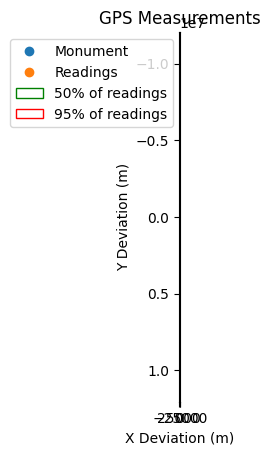

In [80]:
circle_cep = plt.Circle((0,0), radius=CEP, fill=False, color='green')
circle_tdrms = plt.Circle((0,0), radius=TDRMS, fill=False, color = 'red')

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(0, 0, 'o')
ax.plot(delta_x, delta_y, 'o')
ax.set_xlim(left=-max(delta_x), right=max(delta_x))
ax.set_ylim(top=max(delta_y), bottom=-max(delta_y))
ax.add_patch(circle_cep)
ax.add_patch(circle_tdrms)
ax.grid()
ax.set_aspect('equal', adjustable='box')
ax.axvline(0,color='black')
ax.axhline(0,color='black')
ax.set_title("GPS Measurements")
ax.set_xlabel("X Deviation (m)")
ax.set_ylabel("Y Deviation (m)")
ax.legend(["Monument", "Readings", "50% of readings", "95% of readings"])
ax.annotate(f"# of Samples: {N_x}", (-max(test_xx), -max(test_yy)))
plt.show()